
# Cleaning and Model 1
## Model 1: Logistic Regression + Count Vectorizer, $n$ = 2606

In [23]:
##### BASIC IMPORTS 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##### MODELLING IMPORTS 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

##### VECTOR MODELLING IMPORTS 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text  # TO MODIFY STOP WORDS 

In [24]:
# CUSTOM IMPORTS AND SETTINGS 
plt.style.use('gstyle.mplstyle')                        # stylesheet for sns
color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',         # colorlist, color blind palette
                  '#f781bf', '#a65628', '#984ea3',      # from gist.github.com/thriveth/8560036
                  '#999999', '#e41a1c', '#dede00']

sns.set_palette(sns.color_palette(color_cycle))         # setting custom palette

pd.options.display.max_columns = 90                     # view settings
pd.options.display.max_rows = 100

In [25]:
df = pd.read_csv('../data/reddit1000.csv')
df.shape

(3567, 2)

In [26]:
df.rename(columns = {'0': 'corpus'}, inplace=True)          # rename column 0 column to dictionary 
df.drop_duplicates(inplace = True)                          # drop duplicates 
df.dropna(axis=0, inplace = True)                           # drop all nulls
df.shape

(2605, 2)

In [27]:
df.head()

,corpus,class
0,That’s exactly what I did (before refresh) see...,1
1,"I think so, I will be checking daily until it ...",1
2,So it will be reflected on [Tesla.com](https:/...,1
3,"I am in a similar dilemma, have been really wa...",1
4,Did you test drive? How is turning with the ne...,1


## CLEANING 

Same process as for _Model 1_, but twice the volume of data.
1. drop duplicates: superflous
2. drop nulls: unusable 
3. remove newline characters, and link text ( `www`,   `http`,   `com`)
4. remove non-alphabetic characters: superflous, would make vectors needlessly large
5. convert to lower case: reduces dimensional-representation for a single word with various capitalization iterations 
6. will not `lemmatize` or use `stemmer` unless over-fitting necessiates

In [28]:
# rename column 0 column to dictionary 
df.rename(columns = {'0': 'corpus'}, inplace=True)
# drop duplicates 
df.drop_duplicates(inplace = True)
# drop all nulls - likely images
df.dropna(axis=0, inplace = True)
df.shape

(2605, 2)

In [29]:
# removing link strings, newline characters
df['corpus'] = df['corpus'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True)
df.head()

,corpus,class
0,That’s exactly what I did (before refresh) see...,1
1,"I think so, I will be checking daily until it ...",1
2,So it will be reflected on [Tesla.com]( I was ...,1
3,"I am in a similar dilemma, have been really wa...",1
4,Did you test drive? How is turning with the ne...,1


In [30]:
# removing non-alpha characters, which will also eliminate some model #s and model-specific identifiers
df['corpus'] = df['corpus'].replace(r"[^a-zA-Z ]", '', regex = True)
df.head()

# removing non-alpha-numeric charaters
# df['corpus'] = df['corpus'].replace(r"[^a-zA-Z0-9 ]", '', regex = True)
# #r'[0-9]

,corpus,class
0,Thats exactly what I did before refresh seems ...,1
1,I think so I will be checking daily until it c...,1
2,So it will be reflected on Teslacom I was told...,1
3,I am in a similar dilemma have been really wan...,1
4,Did you test drive How is turning with the new...,1


In [31]:
# convert to lower case
df['corpus'] = df['corpus'].str.lower()
df.head()

,corpus,class
0,thats exactly what i did before refresh seems ...,1
1,i think so i will be checking daily until it c...,1
2,so it will be reflected on teslacom i was told...,1
3,i am in a similar dilemma have been really wan...,1
4,did you test drive how is turning with the new...,1


In [32]:
# exporting cleaned file for future import into separate models ? 
df.to_csv('../data/reddit_clean.csv', index = False)

In [33]:
df.shape

(2605, 2)

## MODELING

In [34]:
# start X, y 
# NOTE: CountVectorizer requires a vector, so make sure you set X to be a pandas Series, not a DataFrame.
X = df['corpus']
y = df['class']

In [35]:
# find baseline accuracy
y.value_counts(normalize = True)  

1    0.51094
0    0.48906
Name: class, dtype: float64

In [36]:
# train-test split
# can use "class_weights = " if we want 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

### Pre-processing: 
Setting up custom `stop_words` list to ensure subreddit title and closely-associated terms are not used in model. 

In [37]:
reddit_stopwords = [ 'porsche', 'tesla', 'taycan', 'model', 'car', 'xplaid', 'turbo']
stopwords = text.ENGLISH_STOP_WORDS.union(reddit_stopwords)

### Model 1: Count Vectorizer, selected stopwords, default parameters,

In [38]:
# Instantiate a CountVectorizer
cvec = CountVectorizer(stop_words=stopwords)

In [39]:
# Fit & transform the vectorizer on our training corpus.
Xcvec_train = cvec.fit_transform(X_train)

In [40]:
# Transform the test corpus.
Xcvec_test = cvec.transform(X_test)
Xcvec_train.shape, Xcvec_test.shape 

((1953, 6523), (652, 6523))

#### Preliminary Vizualizations:

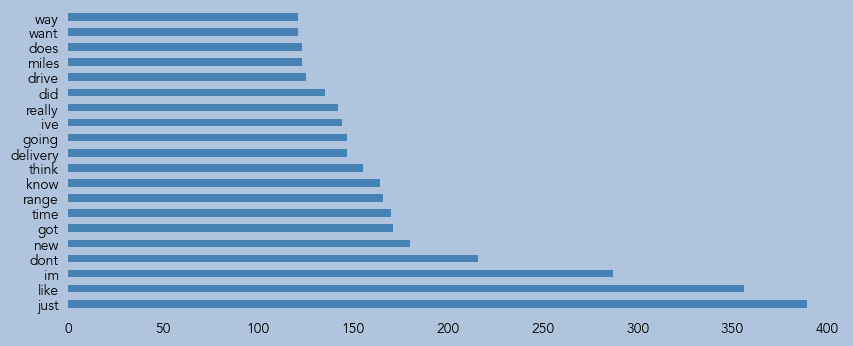

In [41]:
Xcv_train_df = pd.DataFrame(Xcvec_train.todense(), 
                          columns=cvec.get_feature_names())
Xcv_train_df.head()

#plot top occuring words
f, ax = plt.subplots(figsize=(10,4))
ax.tick_params(bottom=False, left = False)  # remove the ticks

Xcv_train_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', color = "steelblue" );

(sns.despine(left=True, bottom=True))

#### Pipeline Setup, Fit, and Score:  

In [42]:
pipe = Pipeline([                                                 # Instantiate
    ('cvec', CountVectorizer(stop_words = stopwords)),            # 1. CountVectorizer (transformer)
    ('model', LogisticRegression())                               # 2. Logistic Regression (estimator)
])

In [50]:
# FIT model
pipe.fit(X_train, y_train);        

In [52]:
### all accuracy metrics 
x= ['x-val', 'RF Train', 'RF Test']
model_mets = [ 
    cross_val_score(pipe, X_train, y_train, cv=3).mean(),   # estimate with x-val
    pipe.score(X_train, y_train),                           # train score 
    pipe.score(X_test, y_test)                              # test score 
     ]
model_mets

[0.7373271889400921, 0.9723502304147466, 0.7515337423312883]

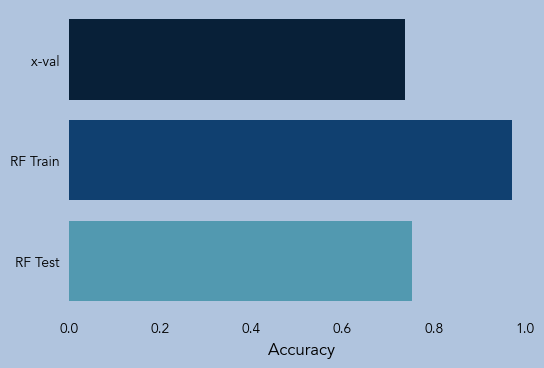

In [46]:
f, ax = plt.subplots(figsize=(6, 4))
ax.tick_params(bottom=False, left = False)  # remove the ticks
plt.xlabel('Accuracy')

sns.despine(left=True, bottom=True)
sns.barplot(y = x, x = model_mets, palette='ocean')
plt.show()


In [47]:
# Get predictions
preds = pipe.predict(X_test)

# # Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cf = confusion_matrix(y_test, preds).ravel()

In [53]:
# precision, specificity, recall 
class_mets = [
    round(tp/(tp + fp), 4),
    round(tn/(tn + fp), 4), 
    round(tp/(tp + fn), 4)
]
class_mets

# higher recall means more Teslas were correcctly IDed, and slightly lower specificity shows poor classification for Taycan

[0.7436, 0.7179, 0.7838]

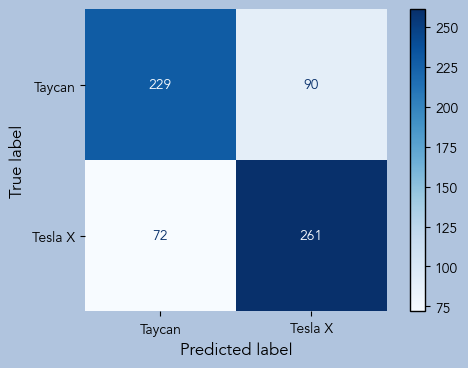

In [48]:
sub_1 = "Tesla X"
sub_2 = "Taycan"

plot_confusion_matrix(pipe, X_test, y_test, cmap = 'Blues', display_labels = [sub_2, sub_1]);
(sns.despine(left=True, bottom=True))

In [49]:
mask = (y_test != preds) & (preds == 0)
false_negatives = pd.DataFrame(X_test[mask])

# exporting missed comments to analyse
df.to_csv('../data/missed01.txt', index = False)

false_negatives[:40]

,corpus
899,i still dont understand the decision for the n...
148,early d here we did a mi round trip road trip...
494,and that is why on occasion i turn on the chil...
685,would you rather take it to the shop seems l...
53,where are you seeing that looks like s for th...
363,all under warranty they did it as part of a se...
709,my model x also received this software version...
627,need to do it tomorrow since i cant do it on m...
130,im driving it you
406,whats your location and what specs there are o...


#### Model 1 performance


Model   | Transformer       | Classifier            | $n$  | x-val   | Train    | Test             
---     |---                | ---                   | ---  | ---     | ---      | ---      
1       | Count Vectorizer  | Logistic Regressor    | 2606 | 0.7373  | 0.9723	| 0.7515  